# Sequence prediction analysis

The Sequence prediction analysis tests are done to analyze several different elements of different algorithms.

### Networks to Evaluate

 - Fully Connected Networks
 - LSTM Networks
 - Other RNNs (bidirectionals, GRUs, ...)
 - TCN (Temporal Convolutional Networks)
 - MANNs (different ones, to determine)
 - Networks Augmented with Attention Mechanisms

### Evaluation Elements:

The following elements must appear in the report of each experiment:

* Algorithm ID (name), reference to the architecture details
* Date
* Time
* Number of Parameters in the network
* Training Time (including the hardware where it was trained)
* Performance (accuracy/something else .. yet to define) at different future points
* Loss (log loss, RMS, etc) at different future points
* Performance decay on the future time, starting from the last training point
* Optimizer used (Adam, Gradient Descent, Momentum, ... etc)
* Input queue size
* Output Queue size
* Feedback Error metric (SME, absolute, log, log-loss, ...) 
* Using/Not using space-time coding (details later, this is something I want to elaborate more and research)
* Comments
* Some others that I have yet to think about

## Assumptions

* The input to the network is standardized for all the models to be tested

#### Architecture

More details in the Architecture Section

* The general architecture is stable, this is, an input queue, an output queue and an error signal that is fed back to the predictor network
* The input is temporally saved in a limited dimension input queue, this queue can or not be used by the network
* The output of the prediction is also kept in an output queue, as before this queue can or not be used by the network
* The error is *always* computed, and is fed back into the network (based on ideas from control systems) in the next time step

#### Resources

* The network must be small enough to be trained in my computer with an Intel i7 7700K and a NVidia GTX 1080

#### Training Data

* All networks will use the same data, pre-processed in the same manner, no specific pre-processing or adaptation should be done
* The input dimension to study is 1D vectors, this means vectors of size (1xN) such as N is a Natural Number
* Training data can be an audio sequence, a list of prices of an exchange, text, MIDI signal, a bitwise signal (example CommaAI-env)


## Architecture

The Architecture is separated in 2 main parts:

1. General Architecture
2. Specific Method Architecture

### General Architecture

The General Architecture can be seen in the following image:

#TODO !!!!!!!!!!!!!!!!!


The architecture consists of an input queue and an output queue. 

The input one provides the data to the predictor network (PN).

The output one stores the predicted data from the predictor network (PN).

An error signal is computed and fed back into the Predictor Network (PN).

### Specific Method Architecture

The point #2 depends on the particularities of the network (LSTM, Fully Connected, Convolutional, etc) so this will be specified in each section separately.



## Input and output queue specificities

The input and output queues can be composed of several queues, these can be the following ones:

1. The actual input data (Mandatory)
2. Time Coding of the input (Optional to be evaluated)
3. Space Coding of the input (Out of scope from the current study)


### The actual input data

This data is the data from the input signal that I'm trying to predict. 

This data can be:

 * A scalar input such as: sound signal, prices from the stock market, temperatures, linear position, ...
 * A Vector input such as text symbols, midi signals, ...
 
### Time Coding of the input
 
This is a code that signifies the TIME at which the input arrives.
 
T his idea comes from the notion that our brain contain not only the symbols arriving in due time, but also there are sensors in our body that allows us to know how much we have moved, how much time has passed, ....

The argument is that for many operations we need this data to actually 

Just to be short without to much reference for the moment (I might write more details on this later):

* in the brain there are neurons that can be stable, unstable, bi-stables and oscilating, 
* that there are some others that are sensitive to location and orientation ( V1 ),
* or spacially related (latest work by deepmind in grid neurons),
* the work on Attention Is All You Need uses positional encoding for words in a sinusoidal maner for this.


### Space Coding for the input

The idea is the same as the Time coding, but for spatial dimensions. This study does not target any evaluation in this domain but is worth to mention it for future work


In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline

In [2]:
import torch
from torch import Tensor
import torch.nn as nn
from torch.nn.utils import rnn
import torch.nn.functional as F
import torch.optim as optim

#torch.manual_seed(1)

In [3]:
use_cuda = torch.cuda.is_available()
print("Is CUDA available? %s." % (use_cuda))

Is CUDA available? True.


In [4]:
# Counting number of parameters
# https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/7
# https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Scalar sequence prediction LSTM Experiment

This experiment tries to deal with the prediction of scalars, nothing else.

### LiteCoin price prediction

Tutorial sources are these:

* http://colah.github.io/posts/2015-08-Understanding-LSTMs/
* https://www.datacamp.com/community/tutorials/lstm-python-stock-market
* http://chandlerzuo.github.io/blog/2017/11/darnn
* https://discuss.pytorch.org/t/rnn-for-sequence-prediction/182
* https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py
* [official documentation](https://pytorch.org/docs/stable/nn.html)



Data is for the moment the one I downloaded some time ago ... I'll give more details later




### Data loading and plotting

In [5]:
ltc = pd.read_csv("~/Crypto/Datasets/cryptocurrencypricehistory/litecoin_price.csv")

In [6]:
ltc.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'], dtype='object')

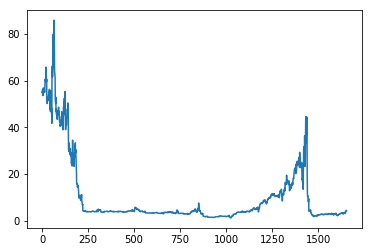

In [7]:
ltc["Open"].plot()

For the first approach to deal with it will use the one present in the datacamp link above.
taking the mid_prices only and scaling them with the scikit-learn MinMaxScaler()

For Information, I do have some other approaches that I'd like to take and are the following ones:

1. Encode prices with a simil taylor series approach as the time-encoding idea
2. Encode not absolute prices but variations between points instead (much less variation), this can be done in absolute (and then scale) or in the same manner as point 1



In [8]:
high_prices = ltc.loc[:,'High'].as_matrix()
low_prices = ltc.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

/home/leo/DeepLearning/venv3/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/leo/DeepLearning/venv3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


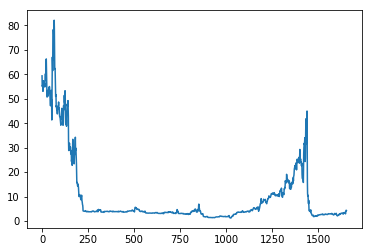

In [9]:
plt.plot(mid_prices)

In [10]:
train_data = mid_prices[:1000]
test_data = mid_prices[1000:]

In [11]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [12]:
train_data.shape

(1000, 1)

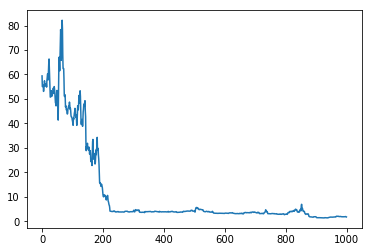

In [13]:
plt.plot(train_data)

In [14]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 100
dtrain = np.zeros(train_data.shape)

for di in range(0,1000,smoothing_window_size):
    dtrain[di:di+smoothing_window_size,:] = scaler.fit_transform(train_data[di:di+smoothing_window_size,:])

dtest = scaler.fit_transform(test_data)

In [15]:
dtrain.shape

(1000, 1)

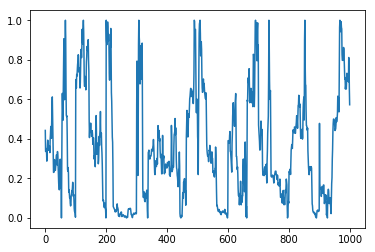

In [16]:
plt.plot(dtrain)

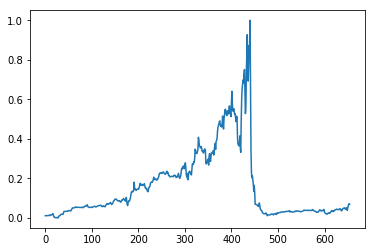

In [17]:
plt.plot(dtest)

In [18]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(1000):
  EMA = gamma*dtrain[ti] + (1-gamma)*EMA
  dtrain[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([dtrain,dtest],axis=0)

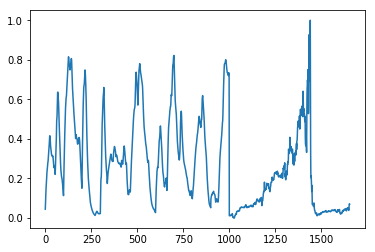

In [19]:
plt.plot(all_mid_data)

In [39]:

class SimpleRecurrentSequence(nn.Module):
    
    # Options that can be used for the recurrent module, this makes the class more general without any change 
    # as pytorch has a nice unified interface for the 3 classes
    module_dict = {
                   "RNN": nn.RNN,
                   "LSTM": nn.LSTM,
                   "GRU": nn.GRU,
                   }
    
    def __init__(self, in_size, hid_size, out_size, layers, future=0, bias=True, dropout=0, batch_size=1,
                 bidirectional=False, cell="LSTM", batch_first=False):
        super(SimpleRecurrentSequence, self).__init__()
        self.in_size = in_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.layers = layers
        self.future = future
        self.batch_size = batch_size
        self.bidirectional = bidirectional
        self.CELL_TYPE = SimpleRecurrentSequence.module_dict[cell]
        self.rnn = self.CELL_TYPE(input_size=in_size, hidden_size=hid_size, num_layers=layers, bias=bias, 
                                  dropout=dropout, bidirectional=bidirectional, batch_first=batch_first)
        self.linear = nn.Linear(hid_size, out_size)
        #self.hidden = self.init_hidden()  #TODO fix the issue with cuda access here
        self.hidden = None

    def forward(self, data, future=0):
        outputs = []
#         print("inshape: ", data.shape)
        out, self.hidden = self.rnn(data, self.hidden) if self.hidden is not None else self.rnn(data)
#         print("shapes: ", out.shape, self.hidden[0].shape)
        out = self.linear(out)
        outputs += [out]
        hidd = self.hidden  # (self.hidden[0].clone(), self.hidden[1].clone())  # I want to avoid that it actually changes the current real state for the next step to avoid future knowledge during training
        output = out  # .view(-1,999,1)
        for i in range(future-1):# if we should predict the future
            out, hidd = self.rnn(out, hidd)
            out = self.linear(out)
            outputs += [out]
        outputs = torch.stack(outputs, 1).squeeze(1)
        return outputs
    
    def init_hidden(self, device): #TODO fix the issue with cuda access -> set device correctly
        n_directions = 2 if self.bidirectional else 1
        return (torch.zeros(self.layers, self.batch_size, self.hid_size).to(device),
                torch.zeros(self.layers, self.batch_size, self.hid_size).to(device))



In [23]:
# train and test data:
# I will be feeding sequences of 30 elements to the RNN, and the output


In [42]:
#np.random.seed(2)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float32')
# torch.save(data, open('traindata.pt', 'wb'))

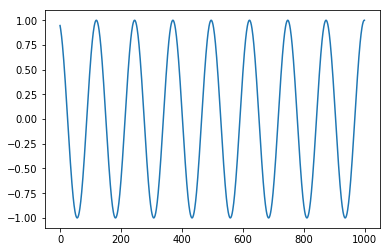

In [43]:
plt.plot(data[72])

In [44]:
in_size = 1
hid_size = 50
out_size = 1
layers = 3
future = 1
bias=True
dropout= 0.
bidirectional= False
cell= "LSTM"
batch_size = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleRecurrentSequence(in_size, hid_size, out_size, layers, future=future, batch_size=batch_size, bias=bias, dropout=dropout, bidirectional=bidirectional, cell=cell)
model.to(device)

SimpleRecurrentSequence(
  (rnn): LSTM(1, 50, num_layers=3)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [45]:
data[:5, :-30].shape

(5, 970)

In [46]:
def train(model, X, Y, future, device):
    criterion = nn.MSELoss() #this loss does not have backward
    #criterion = nn.CrossEntropyLoss() #this loss does not work with the current setup
    # use LBFGS as optimizer since we can load the whole data to train
    #optimizer = optim.LBFGS(model.parameters(), lr=0.8) -> needs a closure() function
    #optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    optimizer = torch.optim.Adam(model.parameters())
    #optimizer = optim.SGD(model.parameters(), lr=0.1)
    #loss = 0
    #hidden = model.init_hidden()
    model.hidden = model.init_hidden(device) #reset state to avoid interference between different elements
    model.zero_grad()
    out = model(X, future=future)
#     print(out.shape)
    loss = criterion(out, Y)
#     print(type(loss))
    loss.backward()
    optimizer.step()
    return loss


In [47]:
%%time

for i in range(20):
    nb= batch_size * i
    nb1 = nb + batch_size
    X = rnn.pad_sequence(torch.from_numpy(data[nb:nb1, :-future]).view(batch_size,L-future,in_size).to(device))
    Y = rnn.pad_sequence(torch.from_numpy(data[nb:nb1, future:]).view(batch_size,L-future, in_size).to(device))
    loss = train(model, X, Y, future, device)
    print("loss = ", loss)

loss =  tensor(0.5025, device='cuda:0')
loss =  tensor(0.5005, device='cuda:0')
loss =  tensor(0.4967, device='cuda:0')
loss =  tensor(0.4934, device='cuda:0')
loss =  tensor(0.4887, device='cuda:0')
loss =  tensor(0.4818, device='cuda:0')
loss =  tensor(0.4770, device='cuda:0')
loss =  tensor(0.4684, device='cuda:0')
loss =  tensor(0.4574, device='cuda:0')
loss =  tensor(0.4440, device='cuda:0')
loss =  tensor(0.4289, device='cuda:0')
loss =  tensor(0.4093, device='cuda:0')
loss =  tensor(0.3842, device='cuda:0')
loss =  tensor(0.3549, device='cuda:0')
loss =  tensor(0.3172, device='cuda:0')
loss =  tensor(0.2749, device='cuda:0')
loss =  tensor(0.2293, device='cuda:0')
loss =  tensor(0.1848, device='cuda:0')
loss =  tensor(0.1538, device='cuda:0')
loss =  tensor(0.1362, device='cuda:0')
CPU times: user 936 ms, sys: 9.04 ms, total: 945 ms
Wall time: 936 ms


In [48]:
#now try to have some fun
model.hidden = None
f = 1000
d = rnn.pad_sequence(torch.from_numpy(data[5, :100]).view(1,100,1).to(device))

In [49]:
d.shape

torch.Size([100, 1, 1])

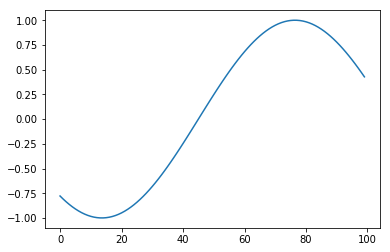

In [51]:
plt.plot(d.view(100,1))

In [54]:
out = model.forward(d, 100)

In [55]:
out.shape

torch.Size([100, 100, 1, 1])

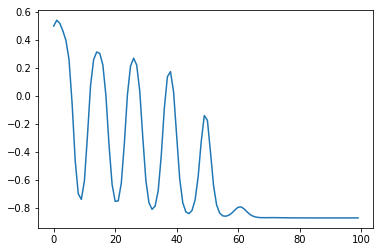

In [57]:
plt.plot(out[1].squeeze(1).squeeze(1).cpu().detach().numpy()[:100])